https://www.kaggle.com/code/nathanbitu/top-12-my-approach-to-house-price-regression

overview:

1) Class to perform data prepreocssing:
    a) read from csv
    b) calculate % of missing value per feature
    c) fill NA with column specific instructions (could be improved using df.get_dtypes(include='numeric'/exclude='numeric))
    d) returns imputed dataset for EDA
    e) log transforms the target variable
    f) one hot encodes

https://www.kaggle.com/code/gomes555/xgboost-bayes-opt-with-tidymodels

1) remove features with high pct of missing value
2) log transform the independent variable, visualize qq plot before/after

### 0. Dependencies :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### 1. Import data:

In [2]:
train_data = pd.read_csv('./res/train.csv')
test_data = pd.read_csv('./res/test.csv')

### 2. Clean, encode data:

#### 2.1 Visualize

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_1016/2860196287.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=missing_percentage.index, x=missing_percentage.values, palette=bar_colors, orient = 'h')
/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_1016/2860196287.py:15: UserWarning: The palette list has more values (81) than needed (19), which may not be intended.
  sns.barplot(y=missing_percentage.index, x=missing_percentage.values, palette=bar_colors, orient = 'h')


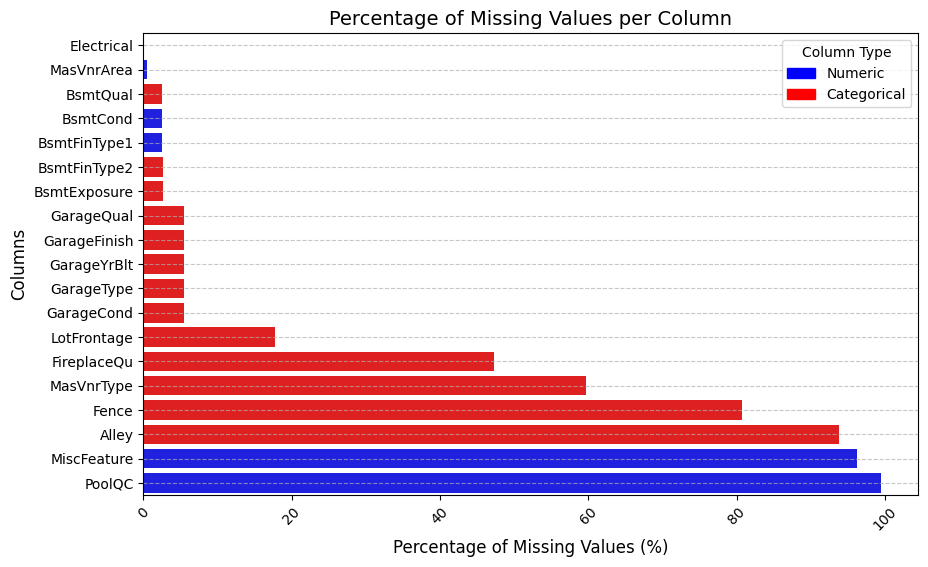

In [3]:
# Calculate the percentage of missing values per column
missing_percentage = train_data.isnull().mean().sort_values() * 100
missing_percentage = missing_percentage[missing_percentage>0]
# sub_train = train_data[[col for col in train_data.columns if col in missing_percentage.index]]

# Determine column types
column_types = train_data.dtypes.apply(lambda dtype: 'Numeric' if np.issubdtype(dtype, np.number) else 'Categorical')

# Assign colors based on column types
color_map = {'Numeric': 'blue', 'Categorical': 'red'}
bar_colors = [color_map[col_type] for col_type in column_types]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(y=missing_percentage.index, x=missing_percentage.values, palette=bar_colors, orient = 'h')
plt.title("Percentage of Missing Values per Column", fontsize=14)
plt.xlabel("Percentage of Missing Values (%)", fontsize=12)
plt.ylabel("Columns", fontsize=12)
plt.xticks(rotation=45)
# plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_map.values()]
labels = list(color_map.keys())
plt.legend(handles, labels, title="Column Type")

plt.show()


#### 2.2 Fill feature NAs

In [4]:
# Fill in the NAs depending on feature type: 'None' if categorical, 0 if numerics
# for type, col in zip(column_types, column_types.index):
#     if col != 'SalePrice':
#         if type == 'Categorical':
#             train_data.loc[:, [col]] = train_data[col].fillna('None')
#             test_data.loc[:, [col]] = test_data[col].fillna('None')
#         else:
#             train_data.loc[:, [col]] = train_data[col].fillna(0)
#             test_data.loc[:, [col]] = test_data[col].fillna(0)

#### 2.3 Target variable distribution normalization

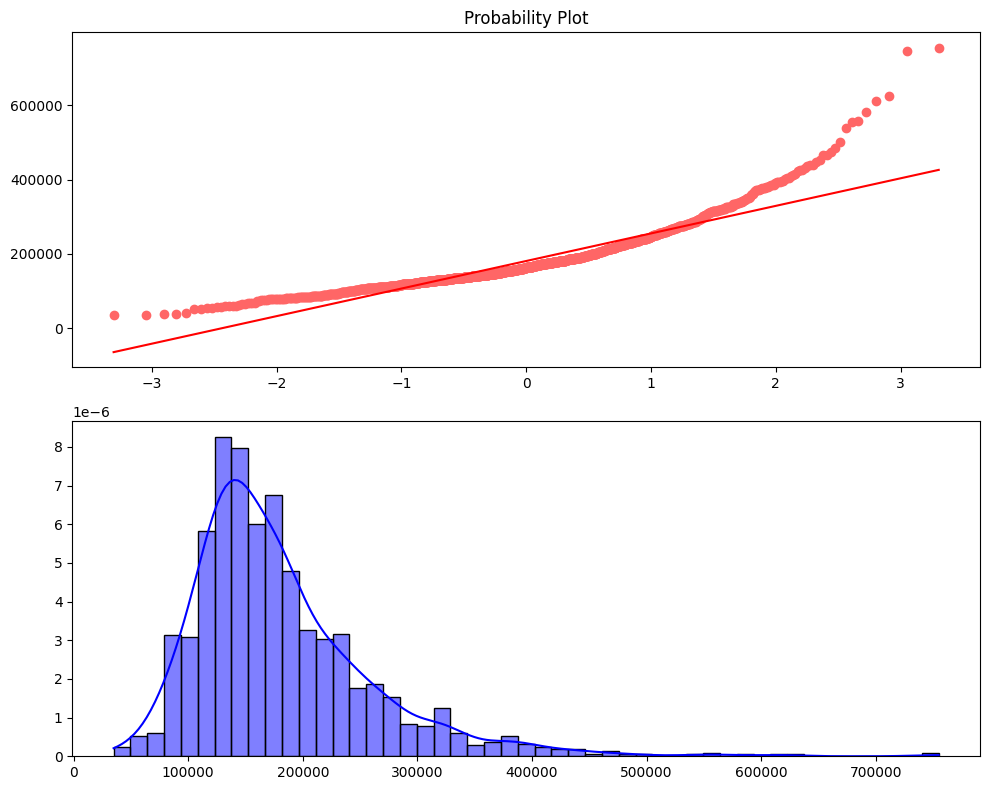

In [5]:
# Create subplots
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# Histogram + Density
ax1 = fig.add_subplot(gs[1, :])
sns.histplot(train_data['SalePrice'], kde=True, stat="density", color="blue", edgecolor="black", ax=ax1)
ax1.set(xlabel="", ylabel="")

# QQ Plot
ax3 = fig.add_subplot(gs[0, :])
stats.probplot(train_data['SalePrice'], dist="norm", plot=ax3)
ax3.get_lines()[0].set_color('#FF6666')  # Customize QQ line
ax3.set(xlabel="", ylabel="")

# Adjust layout
plt.tight_layout()
plt.show()

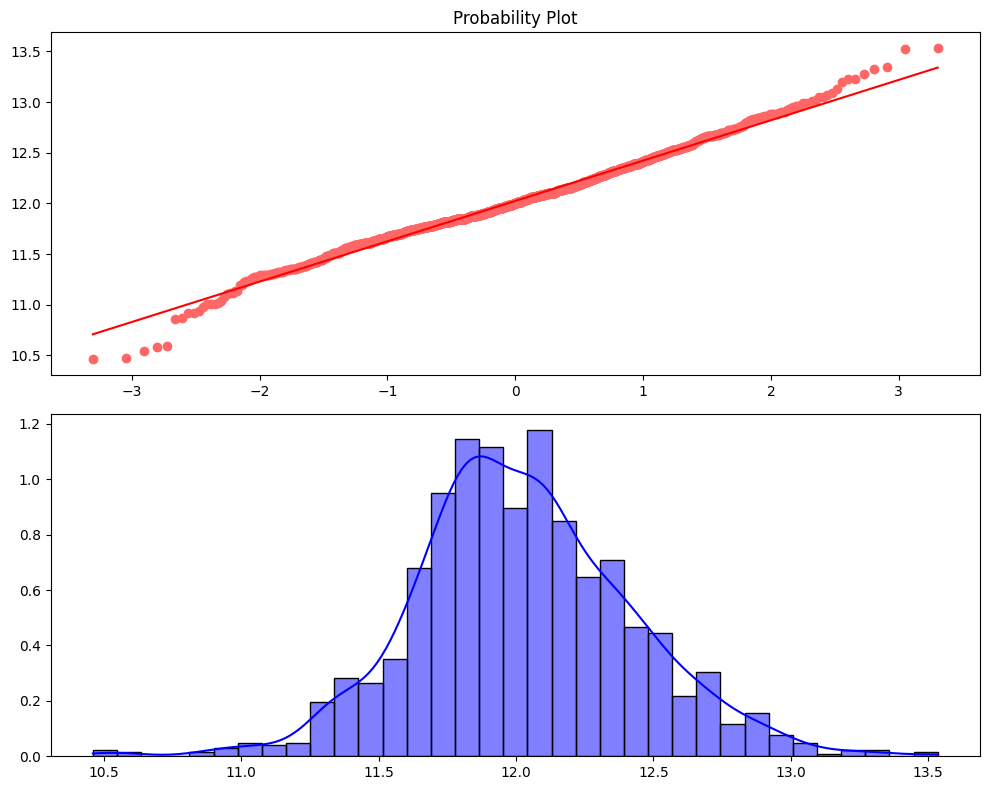

In [6]:
transformed_target = np.log(train_data['SalePrice'])

# Create subplots
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# Histogram + Density
ax1 = fig.add_subplot(gs[1, :])
sns.histplot(transformed_target, kde=True, stat="density", color="blue", edgecolor="black", ax=ax1)
ax1.set(xlabel="", ylabel="")

# QQ Plot
ax3 = fig.add_subplot(gs[0, :])
stats.probplot(transformed_target, dist="norm", plot=ax3)
ax3.get_lines()[0].set_color('#FF6666')  # Customize QQ line
ax3.set(xlabel="", ylabel="")

# Adjust layout
plt.tight_layout()
plt.show()

It looks better after a log transform, let's keep it this way

In [7]:
train_data.loc[:,['SalePrice']] = transformed_target

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_1016/3388291937.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.24769432 12.10901093 12.31716669 ... 12.49312952 11.86446223
 11.90158345]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.loc[:,['SalePrice']] = transformed_target


#### 2.3 Prepare te dataset for training and testing

ideally, we need to perform in order:
- select a number K of folds for cross validation
- operate the train/test split on each fold
- transform the fold data accoding to the PrepareData operations
- fit a Ridge+XGBoost ensemble model to the fold

doing this multiples time to optimise the model hyperparamaters, using a RandomSearchCV !

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column_name_list, all_columns = None):
        self.column_name_list = column_name_list
        self.format = "pandas"
        self.all_columns = all_columns

    def set_output(self, transform = 'pandas'):
        # print('hey')
        if transform not in ['default', 'pandas', 'polars']:
            raise ValueError(
            f"Unable to configure output for DropColumn because `{transform}` "
            "must be in ['default', 'pandas', 'polars']."
        )
        self.format = transform

    def fit(self, X, y):
        return self

    def transform(self, X):
        # print(X.columns)
        X_drop = X.copy()
        for name in self.column_name_list:
            if name in X_drop.columns:
                # print(f'removing {name}...')
                X_drop.drop(labels = name, axis = 1, inplace = True)
        
        # print('out of DropCol: ', X_drop)
        if self.format == 'default':
            # nd arry numpy
            if isinstance(X_drop, np.ndarray):
                return X_drop
            elif isinstance(X_drop, pd.DataFrame):
                return X_drop.to_numpy()
        elif self.format == 'pandas':
            if isinstance(X_drop, pd.DataFrame):
                return X_drop
            elif isinstance(X_drop, np.ndarray):
                # ouch
                return pd.DataFrame(data = X_drop, columns = self.all_columns)
        else:
            raise ValueError(f'unable to return the specified type {self.format}')
        
class LogTransform(BaseEstimator, TransformerMixin):
    def __init__(self, func = np.log, column_name_list = None):
        self.func = func
        self.format = 'pandas'
        self.column_name_list = column_name_list
    
    def set_output(self, transform = 'pandas'):
        if transform not in ['default', 'pandas', 'polars']:
            raise ValueError(
            f"Unable to configure output for DropColumn because `{transform}` "
            "must be in ['default', 'pandas', 'polars']."
        )
        self.format = transform
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        # print("into LogTransform:", X)
        X_log = X.copy() 
        X_log = X_log.map(lambda x: x if isinstance(x, str) or np.isnan(x) else self.func(x))
        # print("out of LogTransform:", X_log)
        # the mapping on the previous line doesn't depend on the cell type, so we can apply irrespective on column dtype
        if self.format == 'default':
            # nd arry numpy
            if isinstance(X_log, np.ndarray):
                return X_log
            elif isinstance(X_log, pd.DataFrame):
                return X_log.to_numpy()
        elif self.format == 'pandas':
            if isinstance(X_log, pd.DataFrame):
                return X_log
            elif isinstance(X_log, np.ndarray):
                # ouch
                return pd.DataFrame(data = X_log, columns = self.all_columns)
        else:
            raise ValueError(f'unable to return the specified type {self.format}')
        

class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, column_name_list = None):
        self.scaler = StandardScaler()
        self.scaler.set_output(transform = 'pandas')
        self.column_name_list = column_name_list # list of numerical predictors

    def fit(self, X, y):
        X_num = X[self.column_name_list].copy()
        self.scaler.fit(X_num, y)
        return self
    
    def transform(self, X):
        # print('into transform of CustomScaler:', X)
        X_num = X[self.column_name_list].copy()
        X_num = self.scaler.transform(X_num)

        X_scaled = X.copy()
        X_scaled.loc[:, self.column_name_list] = X_num
        # print("out of CustomScaler:", X_scaled)
        return X_scaled
    
class GroupInfrequent(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 0.01, column_name_list = None):
        self.threshold = threshold
        self.column_name_list = column_name_list
        self.format = 'pandas'
    
    def set_output(self, transform = 'pandas'):
        if transform not in ['default', 'pandas', 'polars']:
            raise ValueError(
            f"Unable to configure output for DropColumn because `{transform}` "
            "must be in ['default', 'pandas', 'polars']."
        )
        self.format = transform


    def fit(self, X, y):
        return self

    def transform(self, X):
        X_infr = X.copy()
        # print("into transform of GroupInfrequent:", X_infr)
        for col in X_infr.columns:
            if col in self.column_name_list:
                freq = X_infr[col].value_counts(normalize=True)
                rare_categories = freq[freq < self.threshold].index
                X_infr.loc[:,[col]].map(lambda x: 'Other' if x in rare_categories else x)
            
        # print('out of infr col: ',X_infr)
        if self.format == 'default':
            # nd arry numpy
            if isinstance(X_infr, np.ndarray):
                return X_infr
            elif isinstance(X_infr, pd.DataFrame):
                return X_infr.to_numpy()
        elif self.format == 'pandas':
            if isinstance(X_infr, pd.DataFrame):
                return X_infr
            elif isinstance(X_infr, np.ndarray):
                # ouch
                return pd.DataFrame(data = X_infr, columns = self.all_columns)
        else:
            raise ValueError(f'unable to return the specified type {self.format}')
        
class KNNImputerWithLabelEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns,):
        self.imputer = KNNImputer(weights='distance')
        self.imputer.set_output(transform = 'pandas')
        self.encoders = {}
        self.categorical_columns = categorical_columns
        self.format = 'pandas'
        self.all_columns = None

    def set_output(self, transform = 'pandas'):
        if transform not in ['default', 'pandas', 'polars']:
            raise ValueError(
            f"Unable to configure output for DropColumn because `{transform}` "
            "must be in ['default', 'pandas', 'polars']."
        )
        self.format = transform

    def fit(self, X, y=None):
        X_encoded = self._encode_labels(X)
        self.imputer.fit(X_encoded)
        # print('[KNNImpute] running fit, done imputing')
        return self

    def transform(self, X):
        X_columns = X.columns
        self.all_columns = X_columns
        X_encoded = self._encode_labels(X)
        X_imputed = self.imputer.transform(X_encoded)
        # print('[KNNImpute] running transform, done KNN')
        
        return self._decode_labels(X_imputed)

    def _encode_labels(self, X):
        """Encodes categorical features using LabelEncoder."""
        X_encoded = X.copy()
        for column in self.categorical_columns:
            le = LabelEncoder()
            X_encoded.loc[:, [column]] = le.fit_transform(X_encoded[column])
            self.encoders[column] = le
        return X_encoded

    def _decode_labels(self, X_imputed):
        """Inverse transforms the encoded features back to their original categories."""
        X_decoded = X_imputed.copy()
        X_cat = X_decoded[self.categorical_columns]
        X_cat = X_cat.astype(int)
        res = X_cat.copy().astype('object')
        X_num = X_decoded.drop(labels = self.categorical_columns, axis = 1)
        for column, le in self.encoders.items():
            res.loc[:, column] = le.inverse_transform(X_cat[column])#if not astype(int), then the type is 'object' and that throws an error
        X_decoded = pd.concat((X_num, res), axis = 1)
        if self.format == 'default':
            # nd arry numpy
            if isinstance(X_decoded, np.ndarray):
                return X_decoded
            elif isinstance(X_decoded, pd.DataFrame):
                return X_decoded.to_numpy()
        elif self.format == 'pandas':
            if isinstance(X_decoded, pd.DataFrame):
                return X_decoded
            elif isinstance(X_decoded, np.ndarray):
                # ouch
                return pd.DataFrame(data = X_decoded, columns = self.all_columns)
        else:
            raise ValueError(f'unable to return the specified type {self.format}')

class CustomDummy(BaseEstimator, TransformerMixin):
    def __init__(self, column_name_list, all_columns = None):
        self.ohe = OneHotEncoder(handle_unknown='ignore', sparse_output= False)
        self.ohe.set_output(transform = 'pandas')
        self.format = 'pandas'
        self.all_columns = all_columns
        self.column_name_list = column_name_list
    
    def set_output(self, transform = 'pandas'):
        if transform not in ['default', 'pandas', 'polars']:
            raise ValueError(
            f"Unable to configure output for DropColumn because `{transform}` "
            "must be in ['default', 'pandas', 'polars']."
        )
        self.format = transform
        return self

    def fit(self, X, y):
        X_cat = X.copy()
        X_cat = X_cat[self.column_name_list]
        self.ohe.fit(X_cat, y)
        return self
    
    def transform(self, X):
        X_cat = X.copy()
        X_cat = X_cat[self.column_name_list]
        X_dummy = X.copy()
        X_dummy.drop(labels = self.column_name_list, axis = 1, inplace = True)
        X_new_dummies = self.ohe.transform(X_cat)
        X_dummy = pd.concat((X_dummy, X_new_dummies), axis = 1)
        if self.format == 'default':
            # nd arry numpy
            if isinstance(X_dummy, np.ndarray):
                return X_dummy
            elif isinstance(X_dummy, pd.DataFrame):
                return X_dummy.to_numpy()
        elif self.format == 'pandas':
            if isinstance(X_dummy, pd.DataFrame):
                return X_dummy
            elif isinstance(X_dummy, np.ndarray):
                # ouch
                return pd.DataFrame(data = X_dummy, columns = self.all_columns)
        else:
            raise ValueError(f'unable to return the specified type {self.format}')




In [22]:
target = 'SalePrice'
y = train_data[target]
X_feed = train_data[[col for col in train_data if col != target]]

rmv_column_name_list = ['Id', 'Street', 'Utilities', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

numerical_features = [col for col in X_feed.columns if (np.issubdtype(X_feed[col].dtype, np.number) and col != target)]
categorical_features = [col for col in X_feed.columns if (col not in numerical_features and col != target)]

all_predictors = [col for col in X_feed.columns if col != 'SalePrice' and col not in rmv_column_name_list]
all_cat_predictors = [col for col in categorical_features if col not in rmv_column_name_list]
all_num_predictors = [col for col in numerical_features if col not in rmv_column_name_list]
# YrSold is detected as nuùeric feature but could be considered as categorical (order does not imply order in SalePrice, to 2x check)


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

pipin_hot_goo = Pipeline(steps=[
    ('[ALL]_clean_columns', DropColumn(column_name_list=rmv_column_name_list)),

    ('[NUM]_log_transform', LogTransform(np.log1p, column_name_list = all_num_predictors)),
    ('[NUM]_scaling', CustomScaler(column_name_list= all_num_predictors)),

    ('[CAT]_freq_grouping', GroupInfrequent(threshold=0.01, column_name_list = all_cat_predictors)),

    ('[ALL]_knn', KNNImputerWithLabelEncoding(categorical_columns = all_cat_predictors)),

    ('[CAT]_dummy', CustomDummy(column_name_list = all_cat_predictors)),

    ## feature selection ?
    # ('[ALL]_feature_selection', Ridge())

    # Regressor:
    ('xgb_regressor', XGBRegressor()),
])

kf = KFold(n_splits = 5, shuffle = True, random_state=7)

scores = cross_val_score(pipin_hot_goo, X_feed, y, cv = kf, scoring='neg_mean_squared_error', error_score='raise')
print("Mean Squared Error (CV):", -np.mean(scores))

Mean Squared Error (CV): 0.020695583226939738


No data leakage witht the One Hot encoding as the cross_val_score function calls .fit() on the pipeline and then .transform() on respectively the train and the test set that it is fed through the cv= kf arguement.

In [25]:
## 12 min to run in total ##

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from skopt import BayesSearchCV, space

# BayesianOptimisation

search_space = {
    'xgb_regressor__n_estimators': (40, 500),
    'xgb_regressor__max_depth': (1, 50),
    # 'xgb_regressor__min_child_weights': (5, 50),
    'xgb_regressor__gamma': (1e-10, 0.5, 'log-uniform'),
    'xgb_regressor__learning_rate': (0.005, 1.0, 'log-uniform'),
}

bayes_opt = BayesSearchCV(
    estimator=pipin_hot_goo,
    search_spaces=search_space,
    cv = kf,
    # scoring='neg_mean_squared_error',
    scoring = 'neg_root_mean_squared_error',
    verbose=1,
    n_jobs=4,
    n_iter=150,
)

# fit the BayesSearchCV
bayes_opt.fit(X_feed, y)

# Display best parameters and score
print("Best parameters:", bayes_opt.best_params_)
print("Best CV score (MSE):", -bayes_opt.best_score_)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/Users/jordanbonil/Documents/source/git/house_prices/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/Users/jordanbonil/Documents/source/git/house_prices/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [26]:
# Display best parameters and score
print("Best parameters:", bayes_opt.best_params_)
print("Best CV score (MSE):", -bayes_opt.best_score_)

Best parameters: OrderedDict({'xgb_regressor__gamma': 1e-10, 'xgb_regressor__learning_rate': 0.05686444854907629, 'xgb_regressor__max_depth': 4, 'xgb_regressor__n_estimators': 500})
Best CV score (MSE): 0.12753492106347897


In [27]:
# Display best parameters and score
print("Best parameters:", bayes_opt.best_params_)
print("Best CV score (MSE):", -bayes_opt.best_score_)

Best parameters: OrderedDict({'xgb_regressor__gamma': 1e-10, 'xgb_regressor__learning_rate': 0.05686444854907629, 'xgb_regressor__max_depth': 4, 'xgb_regressor__n_estimators': 500})
Best CV score (MSE): 0.12753492106347897


In [33]:
best_estim = bayes_opt.best_estimator_

In [37]:
best_estim.predict(test_data)

array([11.698193 , 11.9263115, 12.134192 , ..., 11.91607  , 11.601078 ,
       12.310002 ], shape=(1459,), dtype=float32)

In [28]:
res = pd.DataFrame(bayes_opt.cv_results_)

In [30]:
# once we have the results, we build the optimal pipeline:

final_model = StackingRegressor(
    estimators = [('pipeline', pipeline)],
    final_estimator = XGBRegressor(
        # colsample_bytree = 0.795287676115978,
        gamma = 1e-10,
        learning_rate = 0.05686444854907629,
        max_depth = 4,
        n_estimators = 500,
        # scale_pos_weight = 195.48202280560275,
    ),
    cv = kf,
)


# final_model = StackingRegressor(
#     estimators = [('pipeline', pipeline)],
#     final_estimator = XGBRegressor(
#         colsample_bytree = 0.374,
#         # gamma = 1e-09,
#         learning_rate = 0.01,
#         max_depth = 14,
#         n_estimators = 294,
#         # scale_pos_weight = 276.21270637104146,
#     ),
#     cv = kf,
# )

# fit the best model
final_model.fit(X, y)


NameError: name 'pipeline' is not defined

In [ ]:
# Let's look at the quality of our fit on train data:

train_pred = np.exp(final_model.predict(X))
train_truth = np.exp(y)

train_truth_and_pred = sorted([[t, p] for t, p in zip(train_truth, train_pred)])
# sort the truth and apply the order to our predictions:

train_truth = np.array([t for t, p in train_truth_and_pred])
train_pred = np.array([p for t, p in train_truth_and_pred])

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(train_truth)), train_truth, alpha=0.7, edgecolor='k', label='Ground Truth')
plt.scatter(np.arange(len(train_truth)), train_pred, label='Train Predictions')


plt.title('Target vs Predictions')
plt.xlabel('sales')
plt.ylabel('SalePrice')
plt.legend()
plt.grid(True)
plt.show()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(train_truth, train_pred, alpha=0.7, edgecolor='k', label='Truth vs Pred')
plt.plot(train_truth, train_truth, color = 'red', label='split line', linestyle = '--')


plt.title('Target vs Predictions')
plt.xlabel('truth')
plt.ylabel('.pred')
plt.legend()
plt.grid(True)
plt.show()

# Plot
plt.figure(figsize=(8, 6))
sq_err = (train_truth-train_pred)**2
plt.scatter(np.arange(len(train_truth)), sq_err, label='Squared Error')

plt.title('Truth to Pred of train data')
plt.xlabel('Err')
plt.ylabel('sales')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
def submit_prediction(model, x_submit):
    preds = np.exp(model.predict(x_submit))
    output = pd.DataFrame({'Id': pd.Index([i for i in range(1461, 2920)]),
                        'SalePrice': preds.squeeze()})
    print(output.head())

    output.to_csv('./out/submission.csv', index = False)

In [40]:
submit_prediction(best_estim, test_data)

     Id      SalePrice
0  1461  120353.992188
1  1462  151192.859375
2  1463  186128.484375
3  1464  190579.828125
4  1465  178346.593750
